<a href="https://colab.research.google.com/github/gil612/PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with Pytorch before.

But how do you get your own data in PyTorch?

Omne of the ways to do so is via: custom datasets.

## Domain libraries

Depending on what you're working on, vision, text, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable daa loading functions.

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0+ os required for this course
torch.__version__

'2.3.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Tue Jul 23 14:44:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food an d 1000 images per class ( 750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small  scale and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Download pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
   print("Unzipping pizza, steak and sushi data...")
   zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one...
Download pizza, steak, sushi data...
Unzipping pizza, steak and sushi data...


## 2. Becoming One with the data (data preparation and data exploaration)

In [5]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its content."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} and {len(filenames)} images in {dirpath}")

In [6]:
walk_through_dir(image_path)

There are 2 and 0 images in data/pizza_steak_sushi
There are 3 and 0 images in data/pizza_steak_sushi/test
There are 0 and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 and 19 images in data/pizza_steak_sushi/test/steak
There are 0 and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 and 0 images in data/pizza_steak_sushi/train
There are 0 and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 and 75 images in data/pizza_steak_sushi/train/steak
There are 0 and 72 images in data/pizza_steak_sushi/train/sushi


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [8]:
# /content/data/pizza_steak_sushi/train/steak/

data/pizza_steak_sushi/test/sushi/1172255.jpg
sushi
Random image path: data/pizza_steak_sushi/test/sushi/1172255.jpg
Image class: sushi
Image height: 383
Image width: 512


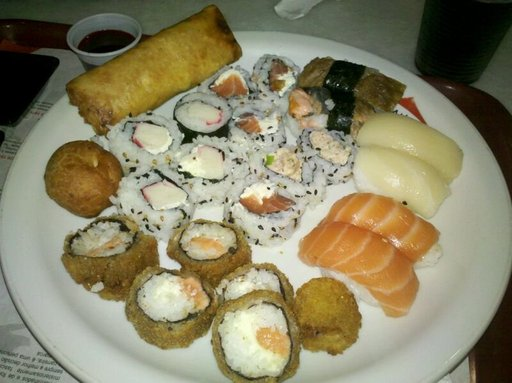

In [9]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
# First star for train and test
# Second star for pizza, steak, sushi folders
# Third star for all .jpg images in those folders
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name (the image class is the name of the directory where the)
image_class = random_image_path.parent.stem
print(image_class)

# Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

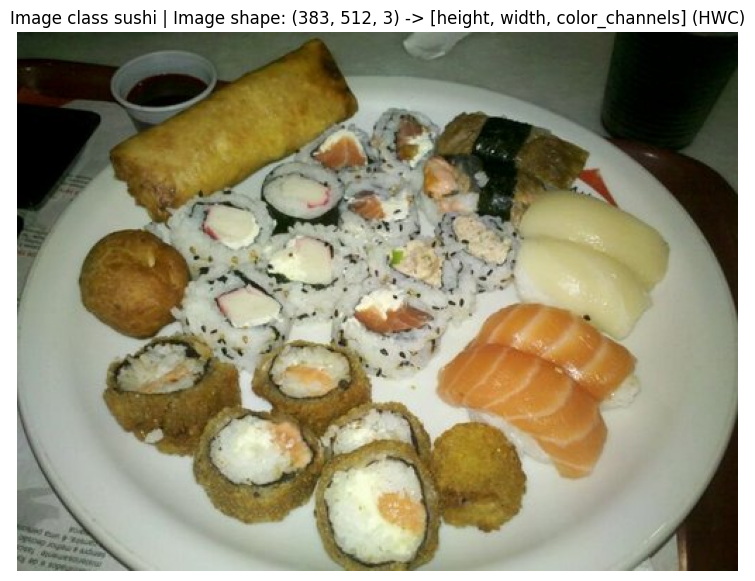

In [10]:
# try to visualize image with matplotlib
import matplotlib.pyplot as plt
import numpy as np # convert image into array

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with maplotlib
plt.figure(figsize=(10,7))

plt.imshow(img_as_array);
plt.title(f"Image class {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[ 21,  33,  21],
        [ 19,  31,  19],
        [ 21,  33,  21],
        ...,
        [ 28,  40,  28],
        [ 32,  44,  32],
        [ 34,  46,  34]],

       [[ 22,  34,  22],
        [ 20,  32,  20],
        [ 21,  33,  21],
        ...,
        [ 28,  40,  28],
        [ 28,  40,  28],
        [ 28,  40,  28]],

       [[ 28,  40,  26],
        [ 26,  38,  24],
        [ 26,  38,  24],
        ...,
        [ 17,  27,  18],
        [ 13,  25,  15],
        [ 12,  24,  14]],

       ...,

       [[127, 130, 119],
        [124, 127, 116],
        [124, 127, 116],
        ...,
        [ 22,  10,   0],
        [ 22,  10,   0],
        [ 22,  10,   0]],

       [[124, 127, 116],
        [122, 125, 114],
        [123, 126, 115],
        ...,
        [ 23,  11,   0],
        [ 23,  11,   0],
        [ 23,  11,   0]],

       [[120, 123, 112],
        [120, 123, 112],
        [121, 124, 113],
        ...,
        [ 23,  11,   0],
        [ 24,  12,   0],
        [ 25,  13,   1]]], dtype=uint8)
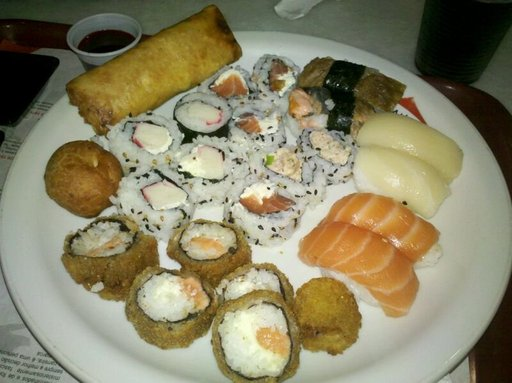

In [11]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn int into a `torch.utils.data.Dataset` and subsequently `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`
Transforms help you get your images ready t be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html

<em>**Transforms are common image transformations.** They can be chained together using Compose. Additionally, there is the torchvision.transforms.functional module. Functional transforms give fine-grained control over the transformations. This is useful if you have to build a more complex transformation pipeline (e.g. in the case of segmentation tasks).All transformations accept PIL Image, Tensor Image or batch of Tensor Images as input. Tensor Image is a tensor with (C, H, W) shape, where C is a number of channels, H and W are image height and width. Batch of Tensor Images is a tensor of (B, C, H, W) shape, where B is a number of images in the batch. Deterministic or random transformations applied on the batch of Tensor Images identically transform all the images of the batch.</em>

In [13]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize out image to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p = 0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])


In [14]:
data_transform(img).shape, data_transform(img).dtype

(torch.Size([3, 64, 64]), torch.float32)

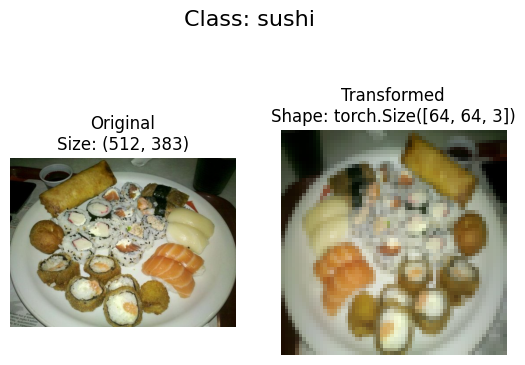

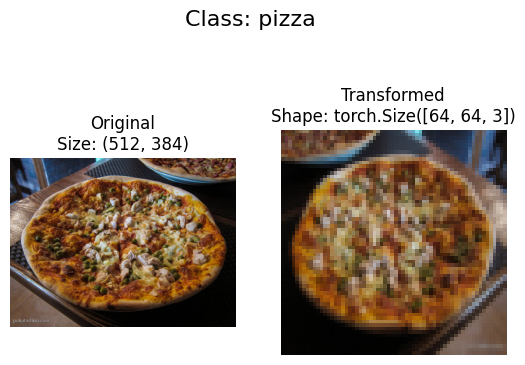

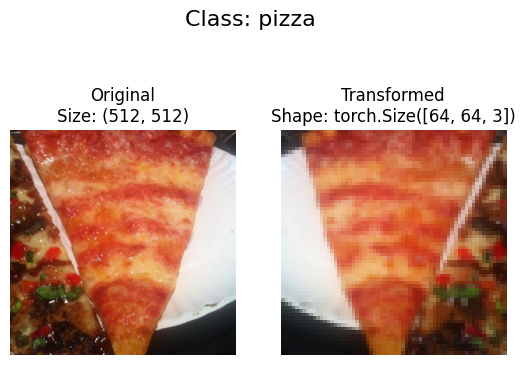

In [15]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """
  Selects random images from a path of images and loads/transforms them then plots the original vs the transormed vesrion
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows= 1, ncols =2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target iamge
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                       transform=data_transform,
                       n=3,
                       seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [16]:
# Use ImageFolder to create dataset(s)
from  torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transorm for the data
                                  target_transform=None) # a transform for the label/target

test_data= datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [18]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [21]:
train_data.samples[1]

('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0)

In [22]:
# Index in the train_data Dataset to get a single image and label
img, label = train_data[0][0], test_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype:{type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

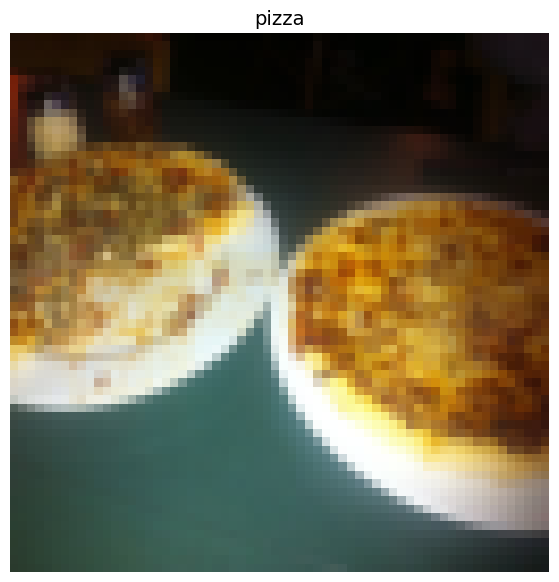

In [23]:
# Rearrange th order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customze the `batch_size` so our model can see `batch_size` images at a time.

In [24]:
import os
os.cpu_count()

2

In [25]:
# turn train and test
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

In [26]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79278809a5c0>,
 <torch.utils.data.dataloader.DataLoader at 0x7927881815d0>)

In [27]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [28]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to Pytorch pre-built `Dataset` functions

Cons:
* Even though you colud create `Dataset` out of  almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All customr datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data#torch.utils.data.DataLoader

In [29]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [30]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is standard image classification format).format
2. Raise an error if the class names aren't found (if this happens, there might be something wring with the directory structure).format.
3. Turn the class names into a dict and a list and return them.

In [31]:
# Setp path for target director
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [32]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [33]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in  a target."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Reaise an error if calsses names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please the file structure.")

  # 3. Create a dictionary of ondex lables (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [34]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create out own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init out subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths
  * transform
  * classes
  * class_to_idx
4. Create a function to `load_images()`, this function will open an image
5. Overwrite `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed a an index  

In [35]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  # MyError: I typed iniit instead of init and got TypeError: ImageFolderCustom() takes no arguments
  def __init__(self,
                  targ_dir: str,
                  transform=None):

    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_images(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6 Overwrite __getitem__() method to return a particuar smaple
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Return one sample of data, data and label (X, y)"
    img = self.load_images(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transmform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label


In [36]:
# Create a transform
from torchvision import transforms
train_transform = transforms.Compose([
                              transforms.Resize(size=(64,64)),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.ToTensor()
                              ])
test_transform = transforms.Compose([
                              transforms.Resize(size=(64,64)),
                              transforms.ToTensor()
                              ])

In [37]:
# Test our ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                      transform=test_transform)

In [38]:
# Not much information
train_data_custom

In [39]:
len(train_data), len(train_data_custom)

(225, 225)

In [40]:
len(test_data), len(test_data_custom)

(75, 75)

In [41]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [42]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [43]:
# Check fo equality between original ImageFodler Dataset and ImageFolderCustom DAtaset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset
5. Setup a matplotlib plot.
6. Loop through random sample images and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC)


In [44]:
# 1. Create  afunction to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape=False
    print(F"For display, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. Set the seed
  if seed:
    random.seed(seed)
  random_samples_idx = random.sample(range(len(dataset)), k= n)

  plt.figure(figsize=(16,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust Tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0) #

    # Plot adjusted saples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
      plt.title(title)

In [45]:
random.sample(range(len(train_data_custom)), k = 10)

[62, 57, 35, 188, 26, 173, 189, 139, 22, 151]

For display, n shouldn't be larger than 10, setting to 10 and removing shape display.


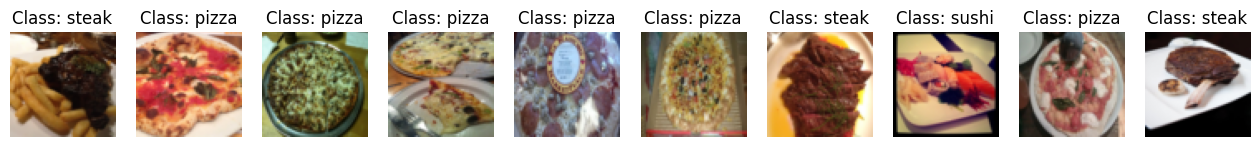

In [46]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data,
                      n = 20,
                      classes = class_names,
                      seed = None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [47]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [48]:
img_custom,  label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data transformers)

Data augmention is the process of artificialy adding diversity to your training data.

In the case of image data, this may mean applying variuos image tranformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to SOTA levels...

Blog post: How to Train State-Of-The-Art Models Using TorchVision’s Latest Primitives
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [49]:
# Let's look at trivialaugment
# num_magnitude_bins [0, 31] - how intense you want the augmentation to happen
from torchvision import transforms
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                                                    transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                                    transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                                                    transforms.ToTensor()])

In [50]:
train_transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
)

In [51]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg')]

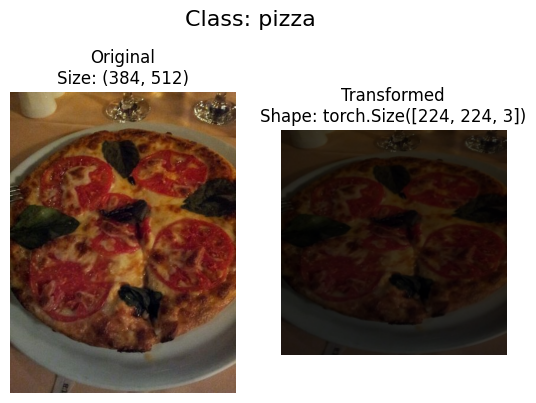

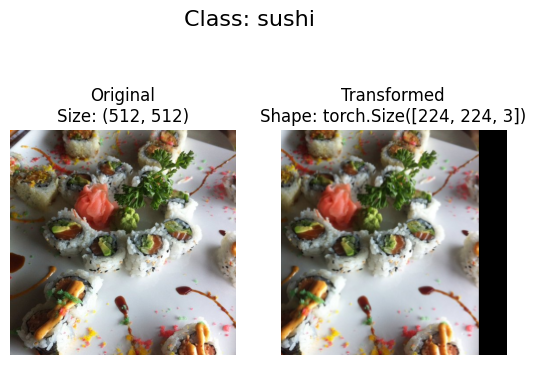

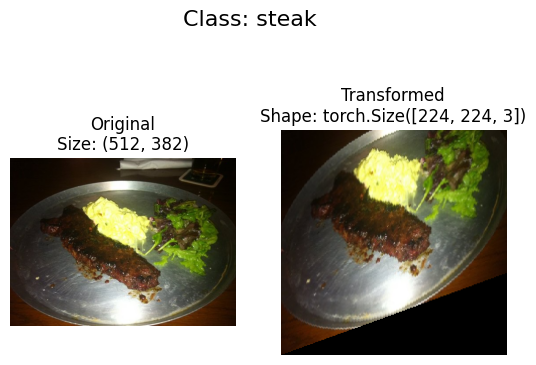

In [52]:
# Plot random tranformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

Let's replicate TinyVGG architecture from the CNN Explainer website

### 7.1 Creating simple transform

In [53]:

simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [54]:
# 1. Laod and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=simple_transform)

import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS=os.cpu_count()

# Create DataLoader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

### 7.2 Creating TinyVGG model class

In [55]:
class TinyVGG(nn.Module):
  def __init__(self,
              input_shape: int,
              hidden_units: int,
              output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential (
        nn.Conv2d(
            in_channels = input_shape,
            out_channels= hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels= hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)

    )
    self.conv_block_2 = nn.Sequential (
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels= hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels = hidden_units,
            out_channels= hidden_units,
            kernel_size=3,
            stride = 1,
            padding = 1
        ),
        nn.MaxPool2d(kernel_size=2,
                     stride = 2)

    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape)
        )
  def forward (self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


In [56]:

torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

In [57]:
# Get
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [58]:
# Try a forward pass
model_0(image_batch.to(device))

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)
## nn.Linear(in_features=hidden_units -> nn.Linear(in_features=hidden_units*16*16

tensor([[0.0572, 0.0564, 0.0452],
        [0.0636, 0.0518, 0.0440],
        [0.0717, 0.0576, 0.0457],
        [0.0740, 0.0589, 0.0526],
        [0.0628, 0.0553, 0.0481],
        [0.0594, 0.0480, 0.0540],
        [0.0596, 0.0531, 0.0499],
        [0.0587, 0.0509, 0.0476],
        [0.0664, 0.0508, 0.0425],
        [0.0638, 0.0469, 0.0491],
        [0.0581, 0.0588, 0.0539],
        [0.0634, 0.0526, 0.0519],
        [0.0653, 0.0560, 0.0553],
        [0.0709, 0.0584, 0.0429],
        [0.0537, 0.0585, 0.0594],
        [0.0635, 0.0568, 0.0563],
        [0.0603, 0.0614, 0.0562],
        [0.0626, 0.0551, 0.0525],
        [0.0575, 0.0520, 0.0501],
        [0.0811, 0.0598, 0.0470],
        [0.0634, 0.0503, 0.0474],
        [0.0652, 0.0524, 0.0472],
        [0.0627, 0.0538, 0.0465],
        [0.0674, 0.0560, 0.0514],
        [0.0651, 0.0521, 0.0501],
        [0.0659, 0.0568, 0.0589],
        [0.0607, 0.0483, 0.0552],
        [0.0790, 0.0607, 0.0529],
        [0.0709, 0.0568, 0.0510],
        [0.066

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [59]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1 ,3, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─MaxPool2d: 2-4                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-5                       [1, 10, 32, 32]           910
│    └─ReLU: 2-6                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-7                       [1, 10, 32, 32]           910
│    └─MaxPool2d: 2-8                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-9                      [1, 2560]                 --
│    └─Line

### 7.5 Create train and test loop functions

* `train_step()`
* `test_step()`

In [60]:
# Create train_step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device = device):

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred=model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # the reason why we're taking the softmax: We're taking the argmax of the logits, just for completeness. It's not 100% necessary
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc



In [61]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [62]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
def train_test_steps():
  torch.manual_seed(42)

  # Measure time

  train_timer_start_on_gpu = timer()

  epochs = 3

  # Create a optimization and evaluation loop using
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=model_0,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
              accuracy_fn=accuracy_fn,
              device=device)

    test_step(model=model_0,
              dataloader=test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [63]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader
def train(model: torch.nn.Module,
               train_dataloader,
               test_dataloader,
               optimizer,
               loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
               epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
              dataloader=train_dataloader,
              loss_fn=loss_fn,
              optimizer=optimizer,
)

    test_loss, test_acc = test_step(model=model,
              dataloader=test_dataloader,
              loss_fn = loss_fn
              )

    print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Indent Error - was inside for loop
  # Return the filled results at the end of the epochs
  return results


### 7.7 Train and evaluate model 0

In [64]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recrwate an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time=timer()

# Train model_0
model_0_results = train(model = model_0,
      train_dataloader=train_dataloader_simple,
      test_dataloader=test_dataloader_simple,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=NUM_EPOCHS)

end_time = timer()
print(end_time-start_time)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1128 | train_acc: 0.2734 | test_loss: 1.1960 | test_acc: 0.2917
Epoch: 2 | train_loss: 1.0795 | train_acc: 0.4297 | test_loss: 1.1785 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1239 | train_acc: 0.2930 | test_loss: 1.1334 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0784 | train_acc: 0.3516 | test_loss: 1.0851 | test_acc: 0.3229
Epoch: 5 | train_loss: 1.0330 | train_acc: 0.4805 | test_loss: 1.0726 | test_acc: 0.4432
Epoch: 6 | train_loss: 0.9901 | train_acc: 0.5078 | test_loss: 1.0664 | test_acc: 0.4337
Epoch: 7 | train_loss: 0.9157 | train_acc: 0.5430 | test_loss: 1.0568 | test_acc: 0.5047
Epoch: 8 | train_loss: 0.7891 | train_acc: 0.6719 | test_loss: 0.9551 | test_acc: 0.5152
Epoch: 9 | train_loss: 0.7374 | train_acc: 0.6992 | test_loss: 0.9539 | test_acc: 0.4640
Epoch: 10 | train_loss: 0.7907 | train_acc: 0.6562 | test_loss: 0.9655 | test_acc: 0.4839
24.65370722600001


In [65]:
model_0_results

{'train_loss': [1.1128481328487396,
  1.079474151134491,
  1.123917669057846,
  1.0784231126308441,
  1.0329588428139687,
  0.9900923073291779,
  0.9157158210873604,
  0.7890867851674557,
  0.7374085932970047,
  0.7907030433416367],
 'train_acc': [0.2734375,
  0.4296875,
  0.29296875,
  0.3515625,
  0.48046875,
  0.5078125,
  0.54296875,
  0.671875,
  0.69921875,
  0.65625],
 'test_loss': [1.1959535678227742,
  1.1784673134485881,
  1.133355696996053,
  1.085103690624237,
  1.0725672245025635,
  1.0664114952087402,
  1.0567549069722493,
  0.9550556937853495,
  0.9539492925008138,
  0.9654790560404459],
 'test_acc': [0.2916666666666667,
  0.19791666666666666,
  0.19791666666666666,
  0.3229166666666667,
  0.4431818181818182,
  0.43371212121212127,
  0.5047348484848485,
  0.5151515151515151,
  0.46401515151515155,
  0.48390151515151514]}

### 7.8 Plot the loss curves of model 0

A **loss curve** is a way of tracking your model's progress over time

In [66]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [67]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training"""
  #
  loss = results["train_loss"]
  test_loss=results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy=results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,7))

  plt.subplot(1,2 ,1)
  plt.plot(epochs, loss, label="train loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

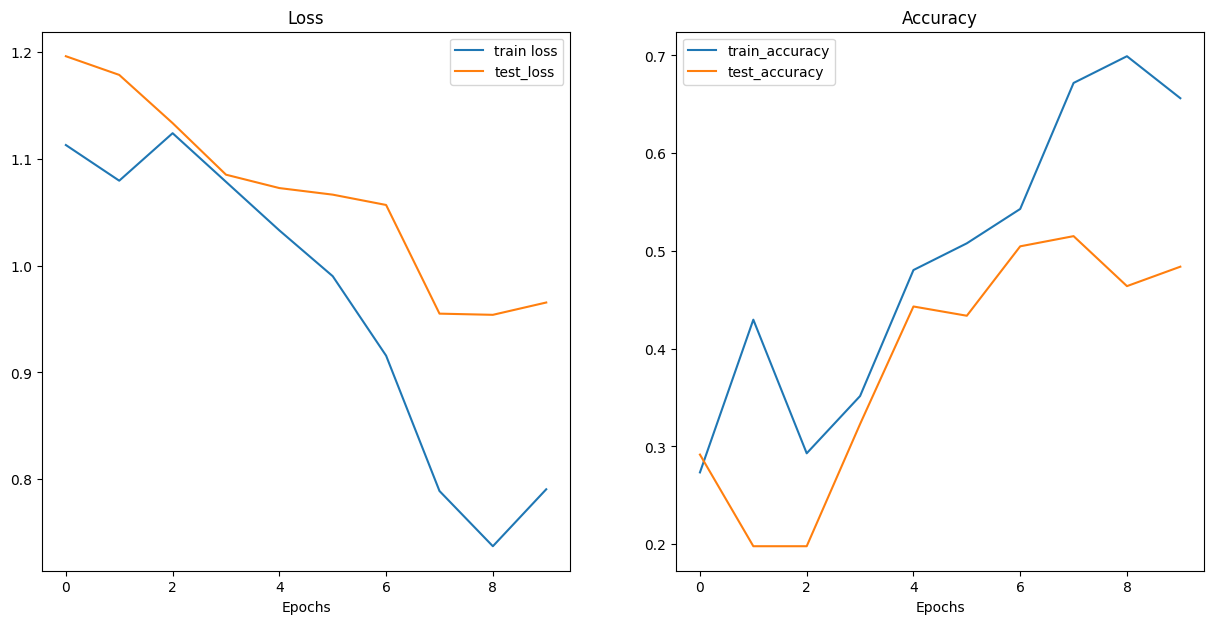

In [68]:
plot_loss_curves(model_0_results)

## 8. Waht should an ideal curve look like?

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modlling experiment thos time using the same model as before with some sata augmentation

### 9.1 Create transform with data augmentation

In [69]:
# Create training with TrivialAugment
from torchvision import transforms
train_trainsform_trivial = transforms.Compose([
                              transforms.Resize(size=(64,64)),
                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                              transforms.ToTensor()])

test_transform_simple = transforms.Compose([
                              transforms.Resize(size=(64,64)),
                              transforms.ToTensor()
                              ])

### 9.2 Create train and test `Dataset`'s and `DataLoader`'s with data augmentation

In [70]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir, transform=train_trainsform_trivial)
test_data_simplr = datasets.ImageFolder(root=test_dir, transform=test_transform_simple)

In [71]:
# Turn out Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

In [72]:
TinyVGG

__main__.TinyVGG

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmeneted the training data.

In [73]:
# Create model_1 and send it to the target device

torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Wonderful! Now we've create a model and dataloaders, let's create a loss function and an optimizer and call upon evaluate our model

In [74]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# MyError: I gave params=model_0.parameters() which resulted in constant test_acc
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model 1
model_1_results=train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# end the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1037 | train_acc: 0.3750 | test_loss: 1.1606 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1797 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1638 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1000 | train_acc: 0.3086 | test_loss: 1.1388 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0923 | train_acc: 0.3203 | test_loss: 1.1202 | test_acc: 0.2500
Epoch: 6 | train_loss: 1.0309 | train_acc: 0.5117 | test_loss: 1.0733 | test_acc: 0.3438
Epoch: 7 | train_loss: 0.9499 | train_acc: 0.5586 | test_loss: 1.0327 | test_acc: 0.4233
Epoch: 8 | train_loss: 1.0149 | train_acc: 0.5391 | test_loss: 1.0134 | test_acc: 0.3617
Epoch: 9 | train_loss: 1.0626 | train_acc: 0.4141 | test_loss: 1.0367 | test_acc: 0.3125
Epoch: 10 | train_loss: 0.9489 | train_acc: 0.5859 | test_loss: 0.8989 | test_acc: 0.6259
Total training time for model_1: 22.740 seconds


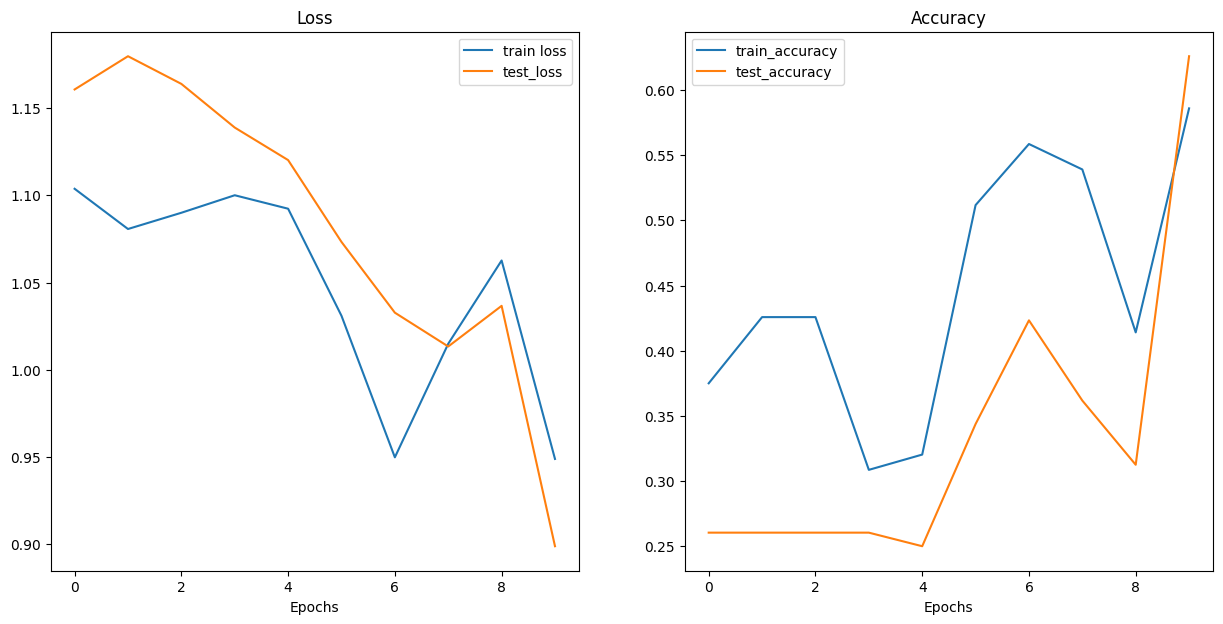

In [75]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding (what we're doing)
2. Pytorch + Tensorboard - https://pytorch.org/docs/stable/tensorboard.html
3. Weights + biases - https://wandb.ai/site/experiment-tracking
4. MLFlow - https://mlflow.org/

In [76]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.112848,0.273438,1.195954,0.291667
1,1.079474,0.429688,1.178467,0.197917
2,1.123918,0.292969,1.133356,0.197917
3,1.078423,0.351562,1.085104,0.322917
4,1.032959,0.480469,1.072567,0.443182
5,0.990092,0.507812,1.066411,0.433712
6,0.915716,0.542969,1.056755,0.504735
7,0.789087,0.671875,0.955056,0.515152
8,0.737409,0.699219,0.953949,0.464015
9,0.790703,0.656250,0.965479,0.483902


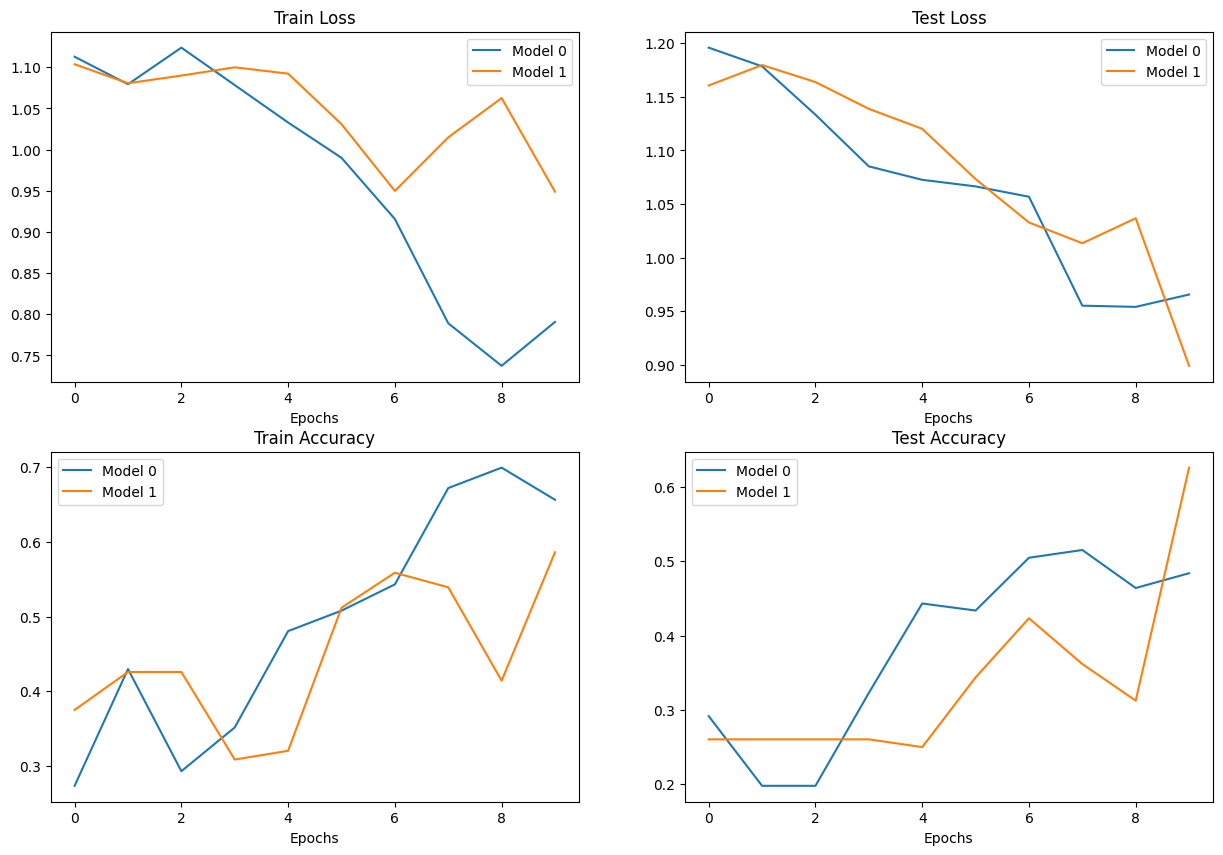

In [77]:
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_results["train_loss"], label="Model 0")
plt.plot(epochs, model_1_results["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_results["test_loss"], label="Model 0")
plt.plot(epochs, model_1_results["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

# Plot train acc
plt.subplot(2,2,3)
plt.plot(epochs, model_0_results["train_acc"], label="Model 0")
plt.plot(epochs, model_1_results["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend();

# Plot test acc
plt.subplot(2,2,4)
plt.plot(epochs, model_0_results["test_acc"], label="Model 0")
plt.plot(epochs, model_1_results["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Making a prediction in a custom image

Although we've trained a model on custom data... how do you make a prediction on a sample/image that's not in either training or testing dataset.


In [81]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pizza1.jpg"

# download the image if it

In [82]:
data_path

PosixPath('data')

### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form with dattype (torch.float32)
* Of shape 64x64x3
* On the right device

We can read an image into Pytorch

In [83]:
import torchvision
import numpy as np
#Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path).type(torch.float32)
# image_uint8 = np.array(custom_image_uint8, dtype=np.uint8)
# new_image = torch.from_numpy(image_uint8.astype(np.float32))
new_image = custom_image_uint8 / 255

print(f"Custom image tensor:\n {new_image}")
print(f"Custom image shape: {new_image.shape}")
print(f"Custom image datatype: {new_image.dtype}")


Custom image tensor:
 tensor([[[0.8275, 0.8314, 0.8392,  ..., 0.8549, 0.8549, 0.8510],
         [0.8353, 0.8392, 0.8471,  ..., 0.8549, 0.8549, 0.8510],
         [0.8510, 0.8510, 0.8588,  ..., 0.8549, 0.8549, 0.8510],
         ...,
         [0.7686, 0.7686, 0.7686,  ..., 0.5373, 0.5451, 0.5569],
         [0.7686, 0.7686, 0.7686,  ..., 0.5412, 0.5569, 0.5686],
         [0.7686, 0.7686, 0.7686,  ..., 0.5490, 0.5647, 0.5765]],

        [[0.8392, 0.8431, 0.8510,  ..., 0.8824, 0.8824, 0.8784],
         [0.8471, 0.8510, 0.8588,  ..., 0.8824, 0.8824, 0.8784],
         [0.8627, 0.8627, 0.8706,  ..., 0.8824, 0.8824, 0.8784],
         ...,
         [0.7922, 0.7922, 0.7922,  ..., 0.5451, 0.5647, 0.5765],
         [0.7922, 0.7922, 0.7922,  ..., 0.5608, 0.5765, 0.5882],
         [0.7922, 0.7922, 0.7922,  ..., 0.5686, 0.5843, 0.5961]],

        [[0.8745, 0.8784, 0.8863,  ..., 0.9216, 0.9216, 0.9176],
         [0.8824, 0.8863, 0.8941,  ..., 0.9216, 0.9216, 0.9176],
         [0.8980, 0.8980, 0.9059,  .

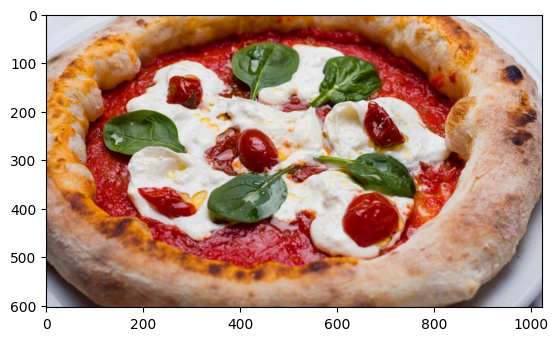

In [84]:
plt.imshow(new_image.permute(1,2,0))

## 11.2 Making a prediction on a custom image with a trained PyTorch model

In [85]:
# model_1.eval()
# with torch.inference_mode():
#   model_1(new_image.to(device))

# RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x142632 and 2560x3)

In [86]:
# Create transform pipeline to resize image
from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(new_image)

# Print out the shapes
print(f"Original shape: {new_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 604, 1024])
Transformed shape: torch.Size([3, 64, 64])


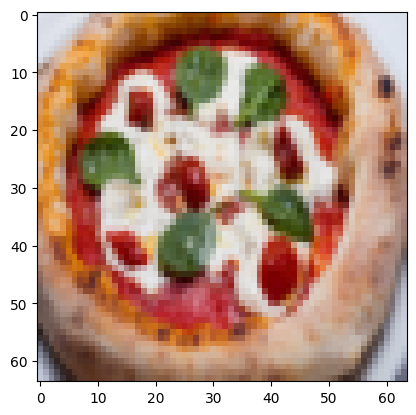

In [87]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [88]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

Note, to make a prediction on a custom image we had to:
* Load the image and turn it into a tensor
* Convert the image to float32
* Divide by 255
* Make sure the image was the same shape as the data the model was trained on (3, 64, 64) with a batch size... (1, 3, 64, 64)
*Make sure the image was on the same device as our model

In [89]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3592, 0.1893, 0.4515]], device='cuda:0')

In [90]:
# Convert prediction probailbities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([2])

In [91]:
class_names[custom_image_pred_label]

'sushi'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image to have our model predict the class of the image + prediction.

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [93]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

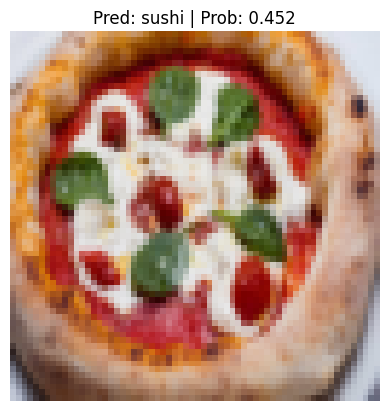

In [94]:
custom_image_path = "/content/data/pizza1.jpg"

from torchvision import transforms
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)